In [1]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme()
url = '../datasets/tidy_data_Part_2_Q4.csv'

In [2]:
df = pd.read_csv(url)

In [3]:
df = df[['season','distance','angle','result_event']]
df = df[df['season']!=20192020]

In [2]:
df_shuffled=df.sample(frac=1).reset_index(drop=True)
# df_shuffled = df_shuffled.drop(df_shuffled[df_shuffled['result_event'] == 'Shot'].sample(frac=.9).index)

NameError: name 'df' is not defined

In [1]:
X = df_shuffled[['distance','angle']].values
Y = df_shuffled['result_event'].values
def convert_to_float(X):
    if X == "Goal":
        return 1.0
    else:
        return 0.0
convert_to_float_v = np.vectorize(convert_to_float)
Y = convert_to_float_v(Y)

NameError: name 'df_shuffled' is not defined

In [6]:
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X,Y)
model = XGBClassifier()
model.fit(X_train,y_train)


C:\Users\xavie\anaconda3\envs\ift6758-conda-env\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\xavie\anaconda3\envs\ift6758-conda-env\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:50:00] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=8,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [7]:
predictions = model.predict(X_val)
accuracy = (predictions == y_val).mean()
print(predictions.all()==0)
print('Accuracy',accuracy)

True
Accuracy 0.905116245522083


0.9331274


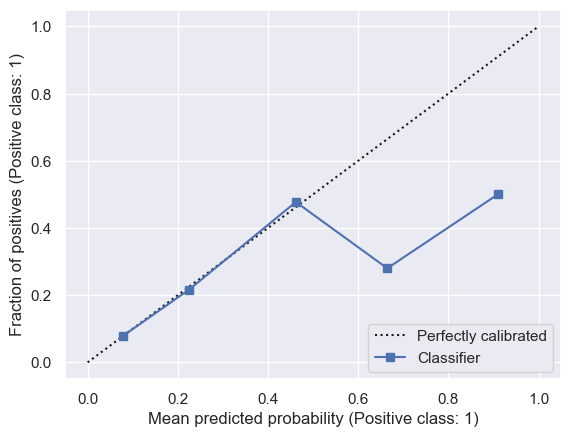

In [8]:
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X,Y)
model = XGBRegressor()
model.fit(X_train,y_train)

y_prob = np.clip(model.predict(X_val),0.0,1.0)
print(y_prob.max())
from sklearn.calibration import CalibrationDisplay
disp = CalibrationDisplay.from_predictions(y_val, y_prob)
plt.show()

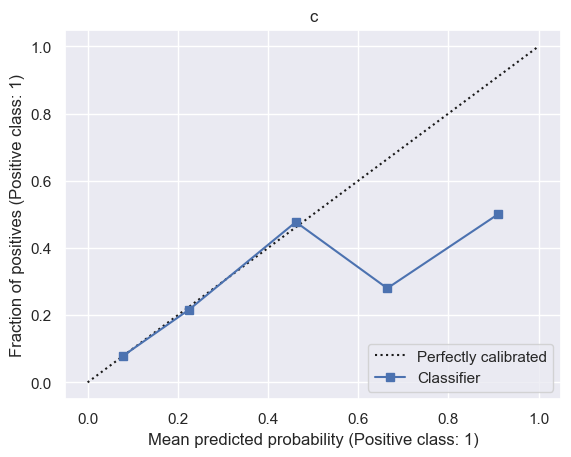

In [9]:
disp = CalibrationDisplay.from_predictions(y_val, y_prob)
disp.ax_.set_title('c')
plt.show()

In [10]:

import sys
import os
from comet_ml import Experiment
dir_ = os.path.dirname(os.getcwd())
if dir_ not in sys.path:
    sys.path.append(dir_)

COMET WARNING: Comet has disabled auto-logging functionality as it has been imported after the following ML modules: xgboost, sklearn. Metrics and hyperparameters can still be logged using comet_ml.log_metrics() and comet_ml.log_parameters()
COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/princesslove/test/34e28eb60a924aaaa4d8397ef2b178d6
COMET INFO:   Metrics:
COMET INFO:     AUC       : 0.4999466170395727
COMET INFO:     Accuracy  : 0.9063424133868679
COMET INFO:     Precision : 0.49264083813594006
COMET INFO:     Recall    : 0.4999466170395727
COMET INFO:     f_score   : 0.475946913497831
COMET INFO:   Uploads:
COMET INFO:     environment details      : 1
COMET INFO:     figures                  : 3
COMET INFO:     filename                 : 1
COMET INFO:     git metadata             : 1
CO

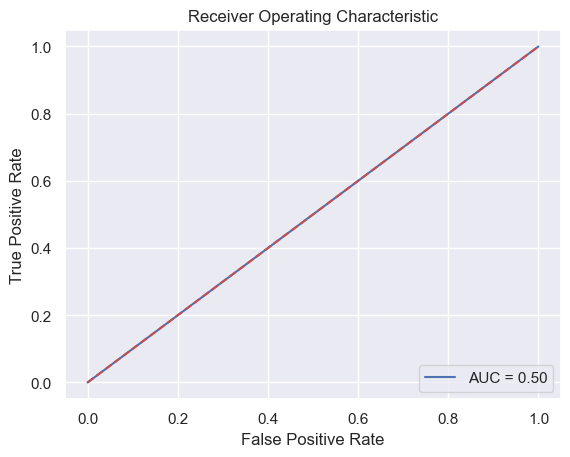

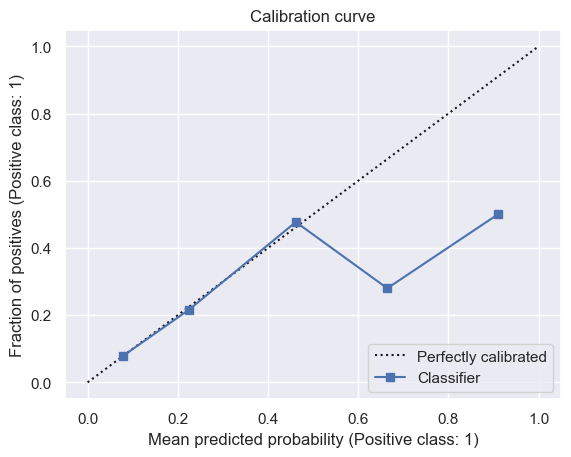

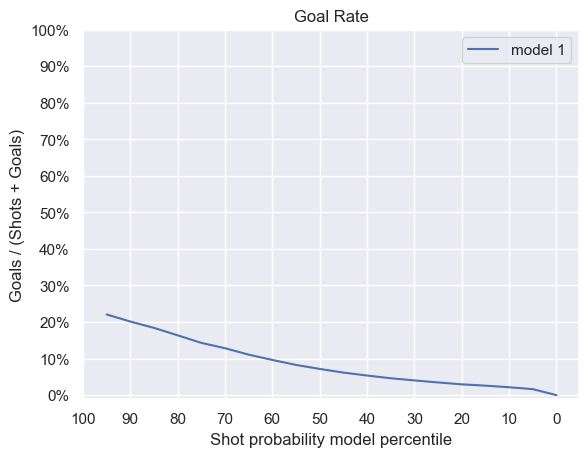

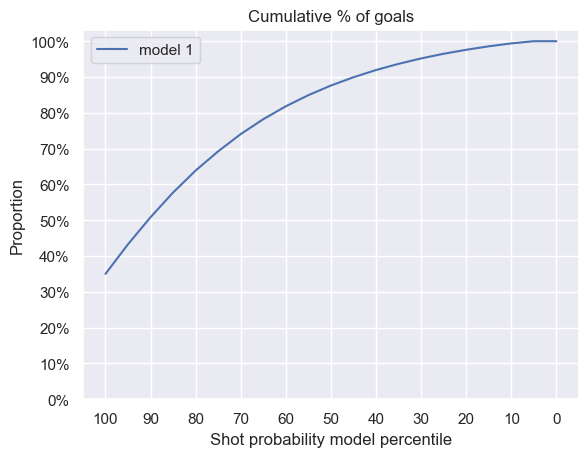

In [12]:
from ift6758.models.plotter import *
experiment = Experiment(
        api_key="j5seGneW8AFUgca6kWUsKRwXa",
        project_name="test",
        workspace="princesslove",
    )
log_All(y_val,predictions,y_prob,experiment)